# Introduction

In this notebook, I've used **CNN** to perform Image Classification on the lung Tumor dataset.<br>


# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.applications.efficientnet import EfficientNetB0
#from keras_efficientnets import EfficientNetB0
#from keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


# Data Preperation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = os.listdir("/content/drive/MyDrive/PFE_IPS/code/code/Data/train/")#labels = ['adenocarcinoma','large.cell.carcinoma','normal','squamous.cell.carcinoma']
labels

['normal', 'adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/PFE_IPS/code/code/Data','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/PFE_IPS/code/code/Data','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 90/90 [00:35<00:00,  2.53it/s]


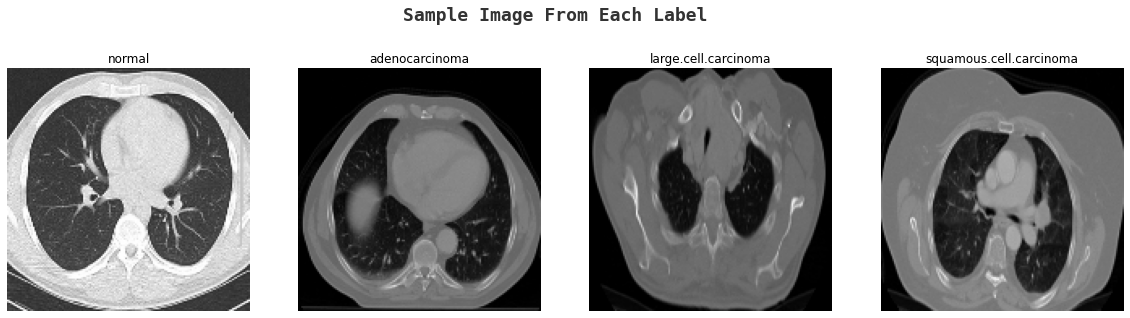

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(1014, 150, 150, 3)

**Image Data Augmentation**: Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. It uses techniques such as flipping, zooming, padding, cropping, etc.<br><br>
Data augmentation makes the model more robust to slight variations, and hence *prevents the model from overfitting.*
<br><br>
To do so using Keras, we use the function **ImageDataGenerator** 

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(1014, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Les modèles de réseaux de neurones à convolution profonde peuvent prendre des jours, voire des semaines, pour s'entraîner sur de très grands ensembles de données.
Un moyen de raccourcir ce processus consiste à réutiliser les poids de modèle à partir de modèles pré-entraînés qui ont été développés pour des ensembles de données de référence de vision par ordinateur standard, tels que les tâches de reconnaissance d'image ImageNet. Les modèles les plus performants peuvent être téléchargés et utilisés directement, ou intégrés dans un nouveau modèle pour vos propres problèmes de vision par ordinateur.

Dans cette réalisation, j'utiliserai le modèle **EfficientNetB3** qui utilisera les poids de l'ensemble de données **ImageNet**.



In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
inputs = Input(shape=(image_size,image_size,3))


In [ ]:
from keras.applications.efficientnet import EfficientNetB3
efficientnetb3= EfficientNetB3(include_top=False, weights='imagenet', 
input_tensor=inputs)

43950080/43941136 [==============================] - 1s 0us/step


In [ ]:
from keras.models import Sequential
def build_model():
    model = Sequential()
    model.add(efficientnetb3)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer="Adam",
        metrics=['accuracy']
    )
    
    return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 5, 5, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 4)                 6148      
Total params: 10,795,827
Trainable params: 10,705,452
Non-trainable params: 90,375
_________________________________________________________________


We finally compile our model.

---

# Training The Model

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   )

Epoch 1/12
26/26 [==============================] - 67s 787ms/step - loss: 0.4897 - accuracy: 0.7146 - val_loss: 0.7014 - val_accuracy: 0.3804
Epoch 2/12
26/26 [==============================] - 15s 569ms/step - loss: 0.1844 - accuracy: 0.9183 - val_loss: 1.0077 - val_accuracy: 0.4783
Epoch 3/12
26/26 [==============================] - 15s 568ms/step - loss: 0.1079 - accuracy: 0.9402 - val_loss: 0.4314 - val_accuracy: 0.6848
Epoch 4/12
26/26 [==============================] - 15s 568ms/step - loss: 0.0835 - accuracy: 0.9598 - val_loss: 0.3428 - val_accuracy: 0.7826
Epoch 5/12
26/26 [==============================] - 15s 568ms/step - loss: 0.0706 - accuracy: 0.9646 - val_loss: 0.3457 - val_accuracy: 0.8261
Epoch 6/12
26/26 [==============================] - 15s 568ms/step - loss: 0.0609 - accuracy: 0.9646 - val_loss: 0.2826 - val_accuracy: 0.7935
Epoch 7/12
26/26 [==============================] - 15s 567ms/step - loss: 0.0402 - accuracy: 0.9793 - val_loss: 0.3083 - val_accuracy: 0.8587

In [ ]:
#history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
 #                  callbacks=[tensorboard,checkpoint,reduce_lr])

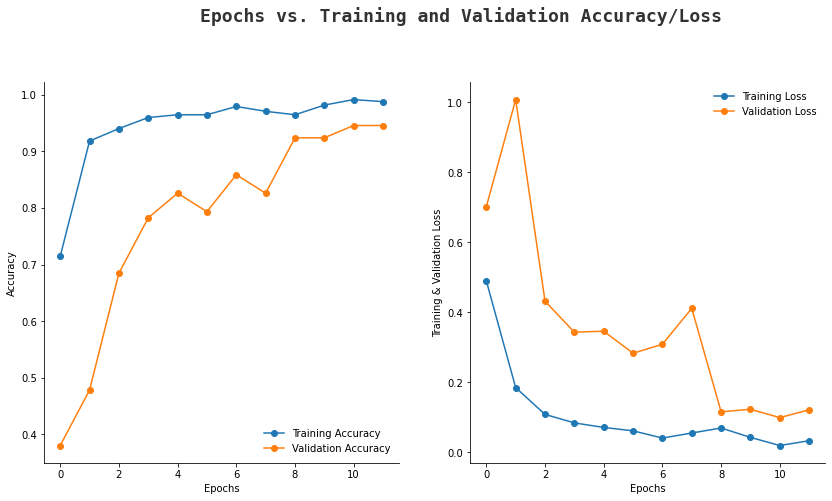

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.savefig("/content/drive/MyDrive/PFE_IPS/Accuracy_Loss.png")
fig.show()

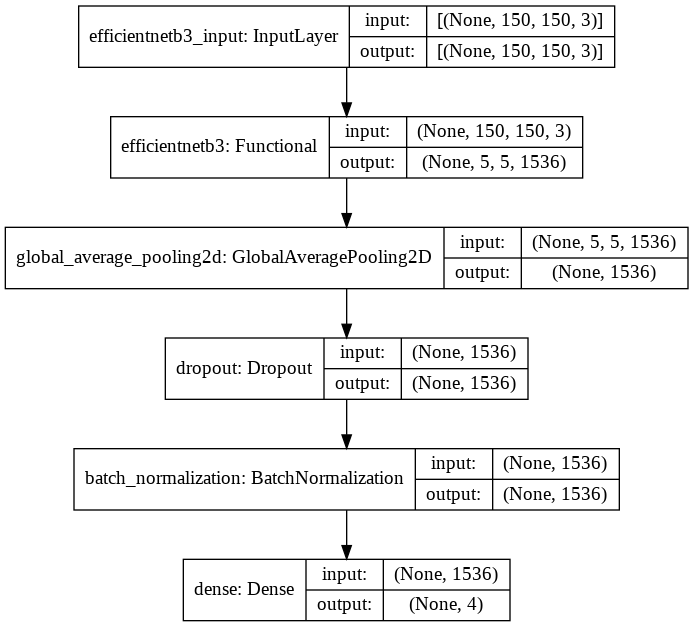

In [ ]:
# Save the visualization as a file

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file="/content/drive/MyDrive/PFE_IPS/A_R_M.png")

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

---

# Evaluation

In this, <br>
0 - normal <br>
1 - adenocarcinoma Tumor<br>
2 - large.cell.carcinoma Tumor<br>
3 - squamous.cell.carcinoma Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        37
           2       1.00      0.93      0.97        15
           3       0.95      1.00      0.97        18

    accuracy                           0.99       102
   macro avg       0.99      0.98      0.98       102
weighted avg       0.99      0.99      0.99       102



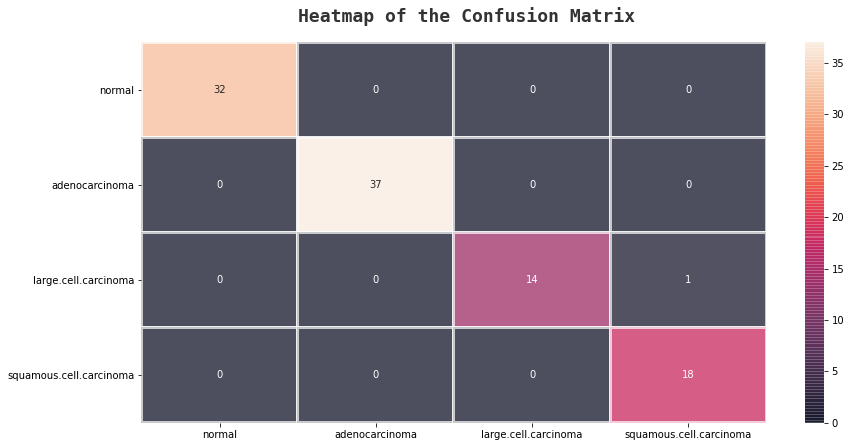

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)
plt.savefig("/content/drive/MyDrive/PFE_IPS/matrix_conf.png")
plt.show()

---

# Bonus Content: Widgets

J'ai créé ces widgets dans lesquels nous pouvons télécharger des images depuis notre machine locale et prédire si l'IRM a une tumor du poumon  ou non et de quelle classe <br>


In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='normal'
    elif p==1:
        print('The model predicts that there is adenocarcinoma Tumor')
    elif p==2:
        p='large.cell.carcinoma Tumor'
    else:
        p='squamous.cell.carcinoma Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

This is where you can upload the image by clicking on the **Upload** button:

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

After uploading the image, you can click on the **Predict** button below to make predictions:

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

# <center>Thank You!